<h1>Building a movie content based recommender using tf-idf</h1>

# Types of recommender systems


* **Content-Based**: Content based recommenders will instead use data exclusively about the items. For this we need to have a minimal understanding of the users’ preferences, so that we can then recommend new items with similar tags/keywords to those specified (or inferred) by the user.

# The MovieLens Dataset

We used **MovieLents** dataset to test our recommender systems which contains rating data sets from the MovieLens web site.

# Data Preparation

In [19]:
# import need library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
from wordcloud import WordCloud

In [20]:
# load data

ratings = pd.read_csv('data_set/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])
users = pd.read_csv('data_set/users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
movies = pd.read_csv('data_set/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

rating file:

In [21]:
ratings.shape

(1000209, 3)

In [22]:
ratings.sample(5)

,user_id,movie_id,rating
167853,1068,653,3
500053,3069,1047,3
203955,1255,927,4
415314,2500,548,4
251031,1516,3948,3


movies file:

In [23]:
movies.shape

(3883, 3)

In [24]:
movies.sample(5)

,movie_id,title,genres
956,968,Night of the Living Dead (1968),Horror|Sci-Fi
3444,3513,Rules of Engagement (2000),Drama|Thriller
3093,3162,Simpatico (1999),Comedy|Drama
3671,3740,Big Trouble in Little China (1986),Action|Comedy
1666,1715,Office Killer (1997),Thriller


users file:


In [25]:
users.shape

(6040, 5)

In [26]:
users.head()

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer


# Data Exploration
### Ratings

Next I want to examine the rating further. One important aspect to consider is the distribution of the user ratings:

<Axes: xlabel='rating', ylabel='count'>

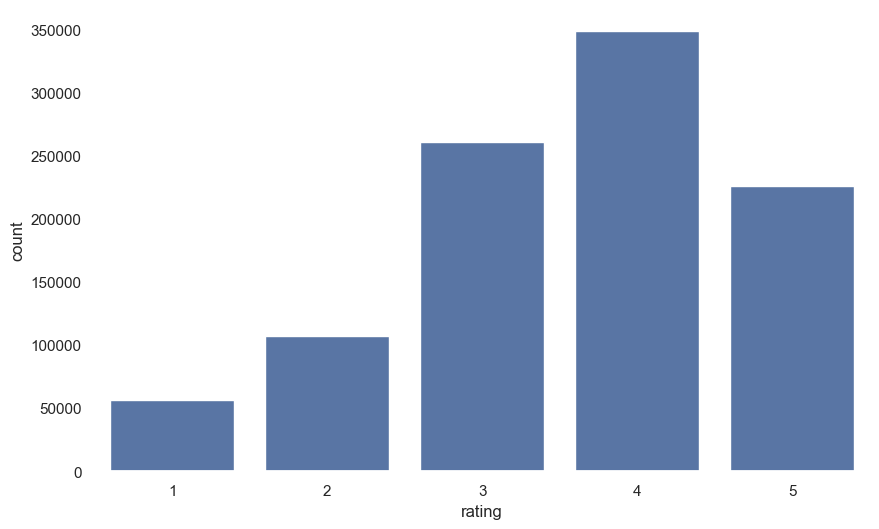

In [27]:
plt.figure(figsize=(10,6))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

sns.countplot(data=ratings, x=ratings['rating'].fillna(ratings['rating'].median()))

* Which are the most popular movies?


We can take a weighted score taking into account both the ratings and the amount of views to answer this question:

In [28]:
def weighted_average_score(df, k=0.8):
    n_views = df.groupby('movie_id', sort=False).movie_id.count()
    ratings = df.groupby('movie_id', sort=False).rating.mean()
    scores = ((1-k)*(n_views/n_views.max()) + 
              k*(ratings/ratings.max())).to_numpy().argsort()[::-1]
    df_deduped = df.groupby('movie_id', sort=False).agg({'title':'first',
                                                         'genres':'first',
                                                         'rating':'mean'})
    return df_deduped.assign(views=n_views).iloc[scores]

In [29]:
df = movies.merge(ratings).merge(users)
weighted_average_score(df).head(10)

,title,genres,rating,views
movie_id,,,,
2858,American Beauty (1999),Comedy|Drama,4.317386,3428
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,4.453694,2991
1198,Raiders of the Lost Ark (1981),Action|Adventure,4.477725,2514
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,4.292977,2990
318,"Shawshank Redemption, The (1994)",Drama,4.554558,2227
527,Schindler's List (1993),Drama|War,4.510417,2304
858,"Godfather, The (1972)",Action|Crime|Drama,4.524966,2223
2028,Saving Private Ryan (1998),Action|Drama|War,4.337354,2653
2762,"Sixth Sense, The (1999)",Thriller,4.406263,2459


### Genres

As we'll explore in the next section, the genres alone can be used to provide a reasonably good content based recommendation. But before that, we need analyse some important aspects.

* Which are the most popular genres?

This will be a relevant aspect to take into account when building the content based recommender. We want to understand which genres really are relevant when it comes to defining a user's taste. A reasonable assumption is that it is precisely the unpopular genres, that will be more relevant in characterising the user's taste.

The most relevant genres are:

In [30]:
genre_popularity = (movies.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity.head(10)

genres
Drama         1603
Comedy        1200
Action         503
Thriller       492
Romance        471
Horror         343
Adventure      283
Sci-Fi         276
Children's     251
Crime          211
Name: count, dtype: int64

Or for a more visual representation we could plot a word-cloud with the genres:

(-0.5, 999.5, 399.5, -0.5)

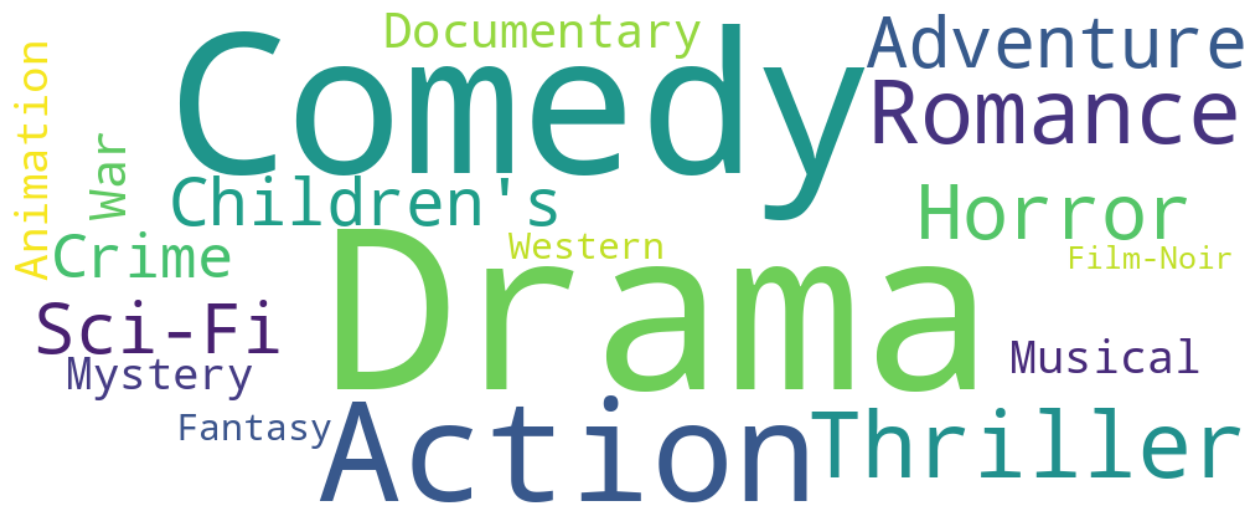

In [31]:
from wordcloud import WordCloud

genre_wc = WordCloud(width=1000,height=400, background_color='white')
genre_wc.generate_from_frequencies(genre_popularity.to_dict())

plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')

## Building a content based recommender 
### Using TF-IDF

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Example of tf-idf vectorization with string

In [33]:
s = "Animation Children's Comedy"
tf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
tf_matrix = tf_vectorizer.fit_transform([s])

feature_names = tf_vectorizer.get_feature_names_out()
print(feature_names)

['animation' 'animation children' 'children' 'children comedy' 'comedy']


In [34]:
#combinations of genres for a given movie
[c for i in range(1,2) for c in combinations(s.split(), r=i)]

[('Animation',), ("Children's",), ('Comedy',)]

In [35]:
#tf-idf Vectorization
tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,4)
                                             for c in combinations(s.split('|'), r=i)))
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 353)

Which will result in the following tf-idf vectors (note that only a subset of the columns and rows is sampled):

In [36]:
pd.DataFrame(tfidf_matrix.todense(), columns=tf.get_feature_names_out(), index=movies.title).sample(5, axis=1).sample(10, axis=0)


,"(Film-Noir,)","(Action, Fantasy, Romance)","(Animation, Children's, Drama)","(Action, Adventure, Thriller)","(Action, Crime, Thriller)"
title,,,,,
"Peacemaker, The (1997)",0.00000,0.0,0.0,0.0,0.0
Albino Alligator (1996),0.00000,0.0,0.0,0.0,0.0
Feeling Minnesota (1996),0.00000,0.0,0.0,0.0,0.0
Grosse Pointe Blank (1997),0.00000,0.0,0.0,0.0,0.0
Devil in a Blue Dress (1995),0.23733,0.0,0.0,0.0,0.0
"General's Daughter, The (1999)",0.00000,0.0,0.0,0.0,0.0
Wayne's World (1992),0.00000,0.0,0.0,0.0,0.0
Lethal Weapon 2 (1989),0.00000,0.0,0.0,0.0,0.0
Eddie (1996),0.00000,0.0,0.0,0.0,0.0


<h2> Similarity between vectors </h2>

In [37]:
#use scikit-learn to compute the cosine similarities between all tf-idf vectors
from sklearn.metrics.pairwise import cosine_similarity

In [38]:
# Cosine Similarity Calculation:
cosine_sim = cosine_similarity(tfidf_matrix)

cosine_sim_df = pd.DataFrame(cosine_sim, index=movies['title'], columns=movies['title'])
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).round(2)




Shape: (3883, 3883)


title,Widows' Peak (1994),Algiers (1938),Dangerous Ground (1997),Permanent Midnight (1998),Hard Rain (1998)
title,,,,,
Toy Story (1995),0.00,0.00,0.00,0.00,0.00
Jumanji (1995),0.00,0.00,0.00,0.00,0.00
Grumpier Old Men (1995),0.00,0.33,0.00,0.00,0.00
Waiting to Exhale (1995),0.39,0.14,0.39,0.39,0.00
Father of the Bride Part II (1995),0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...
Meet the Parents (2000),0.00,0.00,0.00,0.00,0.00
Requiem for a Dream (2000),1.00,0.35,1.00,1.00,0.00
Tigerland (2000),1.00,0.35,1.00,1.00,0.00


In [39]:
#Recommendation function
def genre_recommendations(i, M, items, k=10):
    """
    Recommends movies based on a similarity dataframe

    Parameters
    ----------
    i : str
        Movie (index of the similarity dataframe)
    M : pd.DataFrame
        Similarity dataframe, symmetric, with movies as indices and columns
    items : pd.DataFrame
        Contains both the title and some other features used to define similarity
    k : int
        Amount of recommendations to return

    """
    ix = M.loc[:,i].to_numpy().argpartition(range(-1,-k,-1))
    closest = M.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(i, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

#### Testing the recommender

In [40]:
movies[movies.title.eq('2001: A Space Odyssey (1968)')]

,movie_id,title,genres
912,924,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller


In [41]:
genre_recommendations('2001: A Space Odyssey (1968)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,"X-Files: Fight the Future, The (1998)",Mystery|Sci-Fi|Thriller
1,"Client, The (1994)",Drama|Mystery|Thriller
2,"Talented Mr. Ripley, The (1999)",Drama|Mystery|Thriller
3,Communion (1989),Drama|Sci-Fi|Thriller
4,Gattaca (1997),Drama|Sci-Fi|Thriller
5,"Thirteenth Floor, The (1999)",Drama|Sci-Fi|Thriller
6,Event Horizon (1997),Action|Mystery|Sci-Fi|Thriller
7,2010 (1984),Mystery|Sci-Fi
8,Stalker (1979),Mystery|Sci-Fi
9,Deep Impact (1998),Action|Drama|Sci-Fi|Thriller


In [42]:
print(movies[movies.title.eq('Contact (1997)')])

      movie_id           title        genres
1543      1584  Contact (1997)  Drama|Sci-Fi


In [43]:
genre_recommendations('Contact (1997)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,Nineteen Eighty-Four (1984),Drama|Sci-Fi
1,Twelve Monkeys (1995),Drama|Sci-Fi
2,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi
3,Solaris (Solyaris) (1972),Drama|Sci-Fi
4,Powder (1995),Drama|Sci-Fi
5,"Goodbye, 20th Century (Zbogum na dvadesetiot v...",Drama|Sci-Fi
6,Until the End of the World (Bis ans Ende der W...,Drama|Sci-Fi
7,Conceiving Ada (1997),Drama|Sci-Fi
8,"Brother from Another Planet, The (1984)",Drama|Sci-Fi
9,Close Encounters of the Third Kind (1977),Drama|Sci-Fi


In [44]:
movies[movies.title.eq('Jungle Book, The (1967)')]

,movie_id,title,genres
2009,2078,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical


In [45]:
genre_recommendations('Jungle Book, The (1967)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,Steamboat Willie (1940),Animation|Children's|Comedy|Musical
1,Aladdin (1992),Animation|Children's|Comedy|Musical
2,Hercules (1997),Adventure|Animation|Children's|Comedy|Musical
3,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance
4,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
5,Alice in Wonderland (1951),Animation|Children's|Musical
6,Cinderella (1950),Animation|Children's|Musical
7,Beauty and the Beast (1991),Animation|Children's|Musical
8,"Lion King, The (1994)",Animation|Children's|Musical
9,Cats Don't Dance (1997),Animation|Children's|Musical


In [46]:
movies[movies.title.eq('Saving Private Ryan (1998)')]

,movie_id,title,genres
1959,2028,Saving Private Ryan (1998),Action|Drama|War


In [47]:
genre_recommendations('Saving Private Ryan (1998)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,"Fighting Seabees, The (1944)",Action|Drama|War
1,Glory (1989),Action|Drama|War
2,"Boat, The (Das Boot) (1981)",Action|Drama|War
3,Full Metal Jacket (1987),Action|Drama|War
4,"Patriot, The (2000)",Action|Drama|War
5,G.I. Jane (1997),Action|Drama|War
6,Heaven & Earth (1993),Action|Drama|War
7,"Thin Red Line, The (1998)",Action|Drama|War
8,Braveheart (1995),Action|Drama|War
9,"Longest Day, The (1962)",Action|Drama|War
